# Reinforcement Learning - TD Learning, QLearning and SARSA

<img src="https://raw.githubusercontent.com/jeremiedecock/polytechnique-inf581-2021/master/logo.jpg" style="float: left; width: 15%" />

[INF581-2021](https://moodle.polytechnique.fr/course/view.php?id=9352) Lab session #6

2019-2021 Jérémie Decock

[![Open in Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jeremiedecock/polytechnique-inf581-2021/blob/master/lab6_rl2_tdlearning_qlearning_sarsa_answers.ipynb)

[![My Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/jeremiedecock/polytechnique-inf581-2021/master?filepath=lab6_rl2_tdlearning_qlearning_sarsa_answers.ipynb)

[![NbViewer](https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg)](https://nbviewer.jupyter.org/github/jeremiedecock/polytechnique-inf581-2021/blob/master/lab6_rl2_tdlearning_qlearning_sarsa_answers.ipynb)

[![Local](https://img.shields.io/badge/Local-Save%20As...-blue)](https://github.com/jeremiedecock/polytechnique-inf581-2021/raw/master/lab6_rl2_tdlearning_qlearning_sarsa_answers.ipynb)

## Introduction

The purpose of this lab is to introduce some classic concepts used
in reinforcement learning: *Temporal Difference Learning* (*TD Learning*), *QLearning* and *SARSA*.
$
\newcommand{\vs}[1]{\mathbf{#1}} % vector symbol (\boldsymbol, \textbf or \vec)
\newcommand{\ms}[1]{\mathbf{#1}} % matrix symbol (\boldsymbol, \textbf)
\def\U{V}
\def\action{\vs{a}}       % action
\def\A{\mathcal{A}}        % TODO
\def\actionset{\mathcal{A}} %%%
\def\discount{\gamma}  % discount factor
\def\state{\vs{s}}         % state
\def\S{\mathcal{S}}         % TODO
\def\stateset{\mathcal{S}}  %%%
%
\def\E{\mathbb{E}}
%\newcommand{transition}{T(s,a,s')}
%\newcommand{transitionfunc}{\mathcal{T}^a_{ss'}}
\newcommand{transitionfunc}{P}
\newcommand{transitionfuncinst}{P(\nextstate|\state,\action)}
\newcommand{transitionfuncpi}{\mathcal{T}^{\pi_i(s)}_{ss'}}
\newcommand{rewardfunc}{r}
\newcommand{rewardfuncinst}{r(\state,\action,\nextstate)}
\newcommand{rewardfuncpi}{r(s,\pi_i(s),s')}
\newcommand{statespace}{\mathcal{S}}
\newcommand{statespaceterm}{\mathcal{S}^F}
\newcommand{statespacefull}{\mathcal{S^+}}
\newcommand{actionspace}{\mathcal{A}}
\newcommand{reward}{R}
\newcommand{statet}{S}
\newcommand{actiont}{A}
\newcommand{newstatet}{S'}
\newcommand{nextstate}{\state'}
\newcommand{newactiont}{A'}
\newcommand{stepsize}{\alpha}
\newcommand{discount}{\gamma}
\newcommand{qtable}{Q}
\newcommand{finalstate}{\state_F}
%
\newcommand{\vs}[1]{\boldsymbol{#1}} % vector symbol (\boldsymbol, \textbf or \vec)
\newcommand{\ms}[1]{\boldsymbol{#1}} % matrix symbol (\boldsymbol, \textbf)
\def\vit{Value Iteration}
\def\pit{Policy Iteration}
\def\discount{\gamma}  % discount factor
\def\state{\vs{s}}         % state
\def\S{\mathcal{S}}         % TODO
\def\stateset{\mathcal{S}}  %%%
\def\cstateset{\mathcal{X}} %%%
\def\x{\vs{x}}                    % TODO cstate
\def\cstate{\vs{x}}               %%%
\def\policy{\pi}
\def\piparam{\vs{\theta}}         % TODO pparam
\def\action{\vs{a}}       % action
\def\A{\mathcal{A}}        % TODO
\def\actionset{\mathcal{A}} %%%
\def\caction{\vs{u}}       % action
\def\cactionset{\mathcal{U}} %%%
\def\decision{\vs{d}}       % decision
\def\randvar{\vs{\omega}}       %%%
\def\randset{\Omega}       %%%
\def\transition{T}       %%%
\def\immediatereward{r}    %%%
\def\strategichorizon{s}    %%% % TODO
\def\tacticalhorizon{k}    %%%  % TODO
\def\operationalhorizon{h}    %%%
\def\constalpha{a}    %%%
\def\U{V}              % utility function
\def\valuefunc{V}
\def\X{\mathcal{X}}
\def\meu{Maximum Expected Utility}
\def\finaltime{T}
\def\timeindex{t}
\def\iterationindex{i}
\def\decisionfunc{d}       % action
\def\mdp{\text{MDP}}
$

**Notice**: Here we assume that the reward only depends on the state: $r(\state) \equiv \mathcal{R}(\state, \action, \state')$.

**Notice**: this notebook requires the following libraries: OpenAI *Gym*, NumPy, Pandas and Seaborn.

You can install them with the following command (the next cell does this for you if you use the Google Colab environment):

``
pip install gym numpy pandas seaborn
``

In [ ]:
colab_requirements = [
    "gym",
    "numpy",
    "pandas",
    "seaborn"
]
import sys, subprocess
def run_subprocess_command(cmd):
    # run the command
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    # print the output
    for line in process.stdout:
        print(line.decode().strip())
        
if "google.colab" in sys.modules:
    for i in colab_requirements:
        run_subprocess_command("pip install " + i)

You can uncomment the following cell to install required packages in your local environment (remove only the `#` not the `!`).

In [ ]:
#!pip install gym numpy pandas seaborn

In [3]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import math
import gym
import numpy as np
import copy
import pandas as pd
import seaborn as sns

In [4]:
sns.set_context("talk")

In [5]:
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

## Setup the FrozenLake toy problem with OpenAI Gym

For the purpose of focusing on the algorithms, we will use standard environments provided
by OpenAI Gym framework. Especially, as in Lab 4, we will try to solve the FrozenLake-v0
problem (https://gym.openai.com/envs/FrozenLake-v0/).
As a reminder, this environment is described [here](https://github.com/openai/gym/wiki/FrozenLake-v0).

**Notice**: this environment is *fully observable*, thus here the terms (environment) *state* and (agent) *observation* are equivalent.
This is not always the case for example in poker, the agent doesn't know the opponent's cards.

### Display function

The next cells contain two functions that can be used to display states and Qtables in the FrozenLake environment.

In [6]:
def qtable_display(q_array, title=None, figsize=(4,4), annot=True, fmt="0.1f", linewidths=.5, square=True, cbar=False, cmap="Reds"):
    num_actions = q_array.shape[1]

    global_figsize = list(figsize)
    global_figsize[0] *= num_actions
    fig, ax_list = plt.subplots(ncols=num_actions, figsize=global_figsize)   # Sample figsize in inches

    for action_index in range(num_actions):
        ax = ax_list[action_index]
        state_seq = q_array.T[action_index]
        states_display(state_seq, title=None, figsize=figsize, annot=True, fmt="0.1f", linewidths=.5, square=True, cbar=False, cmap="Reds", ax=ax)

    plt.suptitle(title)
    plt.show()

In [7]:
def states_display(state_seq, title=None, figsize=(5,5), annot=True, fmt="0.1f", linewidths=.5, square=True, cbar=False, cmap="Reds", ax=None):
    size = int(math.sqrt(len(state_seq)))
    state_array = np.array(state_seq)
    state_array = state_array.reshape(size, size)

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)         # Sample figsize in inches

    sns.heatmap(state_array, annot=annot, fmt=fmt, linewidths=linewidths, square=square, cbar=cbar, cmap=cmap, ax=ax)
    
    if title is not None:
        plt.title(title)

    if ax is None:
        plt.show()
    else:
        return ax

## Exercise 1: Implement the TD Learning algorithm

In Lab4, we have seen Dynamic Programming methods that can be used to solve Markov Decision Problems when the environment is perfectly known to the agent i.e. in cases where the agent knows in advance the transition and the reward functions. This is a strong assumption as in most practical problems, these functions are not known in advance. In this lab, we will see how to make agents that can solve Markov Decision Problems without prior knowledge on the environment i.e. agents that learn the dynamics of their environment by exploring it.

We will start with the *TD Learning* (*Temporal Difference Learning*) algorithm that can be used to evaluate a given policy (i.e. compute its *value function* or *V Table*).

---
TD Learning
---

<b>Input</b>:<br>
	$\quad\quad$ the policy $\policy$ to be evaluated<br>
<b>Algorithm parameter</b>:<br>
	$\quad\quad$ step size $\stepsize \in (0,1]$<br><br>

Initialize arbitrarily $\valuefunc(\state) ~~~ \forall \state \in \statespace$<br>
$\valuefunc(\finalstate) = 0 ~~~ \forall \finalstate \in \statespaceterm$ (initialize finale states)<br><br>

<b>FOR EACH</b> episode<br>
	$\quad$ $\statet \leftarrow \text{env.reset}()$<br>
	$\quad$ <b>DO</b> <br>
		$\quad\quad$ $\actiont \leftarrow \pi(\statet)$<br>
		$\quad\quad$ $\newstatet, \reward \leftarrow \text{env.step}(\actiont)$<br>
		$\quad\quad$ $\valuefunc(\statet) \leftarrow \valuefunc(\statet) + \stepsize \left[ \underbrace{\overbrace{\reward + \discount ~ \valuefunc(\newstatet)}^{\text{Target for } \valuefunc(\statet)} ~ - ~ \valuefunc(\statet)}_{\text{TD error}} \right]$<br>
		$\quad\quad$ $\statet \leftarrow \newstatet$<br>
	$\quad$ <b>UNTIL</b> $\statet$ is final

In [8]:
value_function_history = []
alpha_history = []

DISPLAY_EVERY_N_EPISODES = 50

def td_learning(policy, environment, alpha=0.1, alpha_factor=0.995, gamma=0.95, num_episodes=1000, display=False):
    num_states = environment.observation_space.n
    v_array = np.zeros(num_states)   # Initial value function

    for episode_index in range(num_episodes):
        if display and episode_index % DISPLAY_EVERY_N_EPISODES == 0:
            states_display(v_array, title="Value function (ep. {})".format(episode_index), cbar=True, cmap="Reds")
        else:
            print('.', end="")
        value_function_history.append(v_array.copy())
        alpha_history.append(alpha)

        ### BEGIN SOLUTION ###

        state = environment.reset()
        is_final_state = False
        
        if alpha_factor is not None:
            alpha = alpha * alpha_factor

        while not is_final_state:
            action = policy[state]
            new_state, reward, is_final_state, info = environment.step(action)
            
            v_array[state] = v_array[state] + alpha * (reward + gamma * v_array[new_state] - v_array[state])
            
            state = new_state
        
        ### END SOLUTION ###
    
    return v_array

**Note**: In the following cell, the `display` argument can be set to `True` to see the evolution of the value function `v_array` over iterations.

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

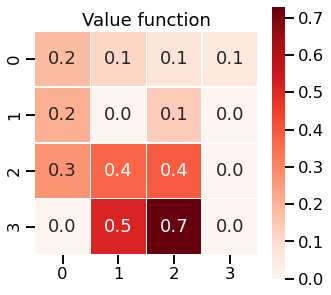

In [9]:
policy = [0, 3, 3, 3,
          0, 0, 0, 0,
          3, 1, 0, 0,
          0, 2, 1, 0]

environment = gym.make('FrozenLake-v0')
environment._max_episode_steps = 1000

v_array = td_learning(policy, environment, display=False)

environment.close()

states_display(v_array, title="Value function", cbar=True, cmap="Reds")

### Display the evolution of the value function over iterations

In [10]:
df_v_hist = pd.DataFrame(value_function_history)
df_v_hist

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
1,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.099500,0.0
2,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.015231,0.082757,0.0
3,0.000000,0.000000e+00,0.000000,0.000000,0.000018,0.0,0.000000,0.0,0.000277,0.000969,0.007134,0.0,0.0,0.019089,0.166894,0.0
4,0.000020,9.894683e-07,0.000000,0.000000,0.000085,0.0,0.000498,0.0,0.000453,0.004852,0.020414,0.0,0.0,0.028553,0.235270,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.181307,1.165991e-01,0.077185,0.058299,0.209451,0.0,0.138508,0.0,0.269569,0.373884,0.392034,0.0,0.0,0.513729,0.728128,0.0
996,0.181274,1.165991e-01,0.077185,0.058299,0.209341,0.0,0.138508,0.0,0.269651,0.373951,0.391984,0.0,0.0,0.513734,0.727913,0.0
997,0.181267,1.165452e-01,0.077154,0.058349,0.209468,0.0,0.138464,0.0,0.269732,0.374021,0.392010,0.0,0.0,0.513413,0.728096,0.0
998,0.181288,1.164838e-01,0.077104,0.058397,0.209333,0.0,0.138328,0.0,0.269773,0.373861,0.391660,0.0,0.0,0.513413,0.728096,0.0


Evolution of `v_array` (the estimated value of each state) over iterations (one curve per state):

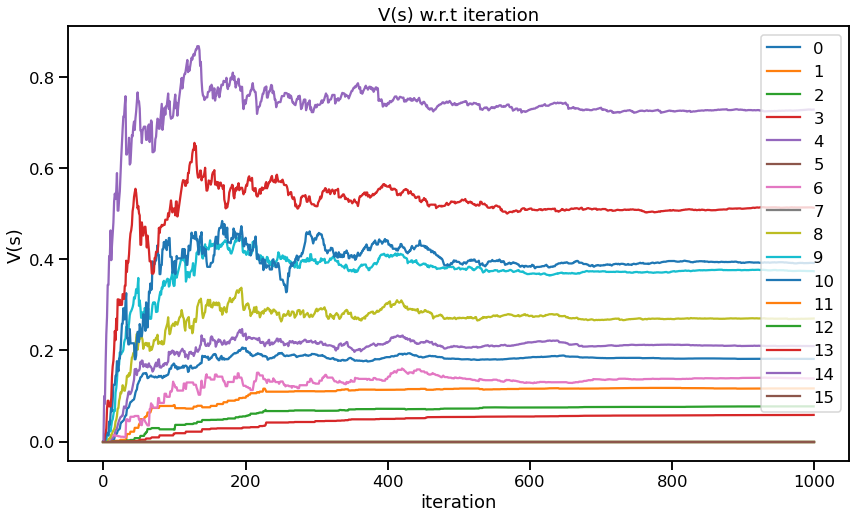

In [11]:
df_v_hist.plot(figsize=(14,8))
plt.title("V(s) w.r.t iteration")
plt.ylabel("V(s)")
plt.xlabel("iteration")
plt.legend(loc='upper right');

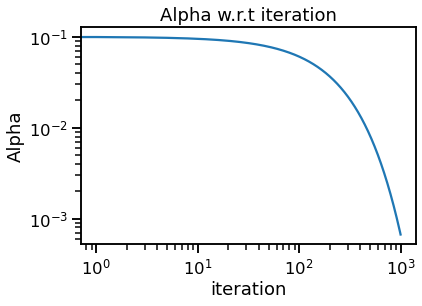

In [12]:
plt.loglog(alpha_history)
plt.title("Alpha w.r.t iteration")
plt.ylabel("Alpha")
plt.xlabel("iteration");

## Exercise 2: The learning rate $\alpha$ in TD-Learning

In the previous exercise, set `alpha_factor` to 1 and check the algorithm with different values between 0 and 1.

What do you observe ?
What is the role of `alpha_factor` ?

## Exercise 3: Implement the Greedy and Epsilon Greedy policies

In the previous exercise, TD-Learning has been used to **estimate the value** of a **given policy**.
In the following exercises, we will now see how to **find the optimal** (or a nearly optimal) policy.
For that, we will use two algorithms (SARSA and QLearning) that estimate a *QTable* (or *action-value function*) instead of a VTable (or value function).
This QTable gives the expected reward when the agent plays a given action $\action$ from any given state $\state$ and then follow a given *exploration policy* to choose the following actions until a final state is reached (and this exploration policy uses the QTable to choose actions to play).
While the agent explore the environment, it update it's QTable using an *update policy*.

The purpose of this second exercise is to implement the *greedy* and the $\epsilon$-*greedy* policies that agents will used to explore the environment and update their QTable:

$\displaystyle \policy^{\qtable}(\state) := \text{greedy}(\state, \qtable) = \arg\max_{\action \in \actionspace} \qtable(\state, \action)$


$\policy^{\qtable,\epsilon}(\state) := \epsilon\text{-greedy}(\state, \qtable) = $
randomly choose between $\underbrace{\text{greedy}(\state, \qtable)}_{\text{with probability } 1 - \epsilon}$
and $~~ \underbrace{\text{a random action}}_{\text{with probability } \epsilon}$    i.e. $\epsilon \in (0,1]$

In [13]:
def greedy_policy(state, q_array):

    ### BEGIN SOLUTION
    action = np.argmax(q_array[state, :])
    ### END SOLUTION

    return action


def epsilon_greedy_policy(state, q_array, epsilon):

    ### BEGIN SOLUTION
    if np.random.rand() < epsilon:
        action = np.random.randint(q_array.shape[1])
    else:
        action = greedy_policy(state, q_array)
    ### END SOLUTION

    return action

## Exercise 4: Implement the SARSA algorithm

To find the optimal policy (or a nearly optimal policy) for the FrozenLake-v0 problem, we will first use the SARSA algorithm.
It is based on the online update of the so-called Q-function for the current policy defined as:
$$
Q^{\pi}(s, a) = \mathbb{E}^{\pi} \left[ \sum_{t=0}^{H} \gamma^t r(s_t, a_t) | s=s_0, a=a_0 \right] ,
$$
where $\gamma \in [0, 1]$ is the discount factor, and $H$ the horizon of the episode.

The SARSA algorithm updates a tabular estimate of the Q-function using the following update rule:
$$
Q_{t+1} (s_t , a_t) \leftarrow Q_t(s_t, a_t) + \alpha \left( r_t + \gamma Q_t(s_{t+1}, a_{t+1}) - Q_t(s_t, a_t) \right) ,
$$
where $\alpha \in (0, 1]$ is the learning rate, and $r_t$ is the reward received by the agent at time step $t$.
Most of the time, the SARSA algorithm is implemented with an $\epsilon$-greedy exploration strategy.
This strategy consists in selecting the best action learned so far with probability $(1 - \epsilon)$ and to select a random
1action with probability $\epsilon$.

**Tasks**: Implement the SARSA algorithm with $\epsilon$-greedy exploration (start with $\epsilon = 0.5$).

---
SARSA
---

<b>Input</b>:<br>
	$\quad\quad$ none<br>
<b>Algorithm parameter</b>:<br>
	$\quad\quad$ discount factor $\discount$<br>
	$\quad\quad$ step size $\stepsize \in (0,1]$<br>
	$\quad\quad$ small $\epsilon > 0$<br><br>

Initialize arbitrarily $\qtable(\state, \action) ~~~ \forall \state \in \statespace, \action \in \actionspace(\state)$<br>
$\qtable(\finalstate, \cdot) = 0 ~~~ \forall \finalstate \in \statespaceterm$ (initialize finale states)<br><br>

<b>FOR EACH</b> episode<br>
	$\quad$ $\statet \leftarrow \text{env.reset}()$<br>
	$\quad$ $\actiont \leftarrow \epsilon\text{-greedy}(\statet, Q)$<br>
	$\quad$ <b>DO</b> <br>
		$\quad\quad$ $\reward, \newstatet \leftarrow \text{env.step}(\actiont)$<br>
		$\quad\quad$ $\newactiont \leftarrow \epsilon\text{-greedy}(\newstatet, Q)$<br>
		$\quad\quad$ $Q(\statet,\actiont) \leftarrow Q(\statet,\actiont) + \stepsize \left[ \underbrace{\reward + \discount ~ Q(\newstatet,\newactiont) ~ - ~ Q(\statet,\actiont)}_{\text{TD error}} \right]$<br>
		$\quad\quad$ $\statet \leftarrow \newstatet$<br>
		$\quad\quad$ $\actiont \leftarrow \newactiont$<br>
	$\quad$ <b>UNTIL</b> $\statet$ is final

In [14]:
q_array_history = []
alpha_history = []

DISPLAY_EVERY_N_EPISODES = 50

def sarsa(environment, alpha=0.1, alpha_factor=0.9995, gamma=0.99, epsilon=0.5, num_episodes=10000, display=False):
    num_states = environment.observation_space.n
    num_actions = environment.action_space.n
    q_array = np.zeros([num_states, num_actions])   # Initial Q table

    for episode_index in range(num_episodes):
        if display and episode_index % DISPLAY_EVERY_N_EPISODES == 0:
            qtable_display(q_array, title="Q table", cbar=True)
        else:
            print('.', end="")
        q_array_history.append(q_array.copy())
        alpha_history.append(alpha)

        ### BEGIN SOLUTION ###

        is_final_state = False

        state = environment.reset()
        action = epsilon_greedy_policy(state, q_array, epsilon)

        # Update alpha
        if alpha_factor is not None:
            alpha = alpha * alpha_factor

        while not is_final_state:
            new_state, reward, is_final_state, info = environment.step(action)
            new_action = epsilon_greedy_policy(new_state, q_array, epsilon)

            #if reward > 0:
            #    print(reward)

            #if is_final_state:
            #    print(state)

            q_array[state, action] = q_array[state, action] + alpha * (reward + gamma * q_array[new_state, new_action] - q_array[state, action])

            state = new_state
            action = new_action

        ### END SOLUTION ###

    return q_array

**Note**: In the following cell, the `display` argument can be set to `True` to see the evolution of the action-value function `q_array` over iterations.

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

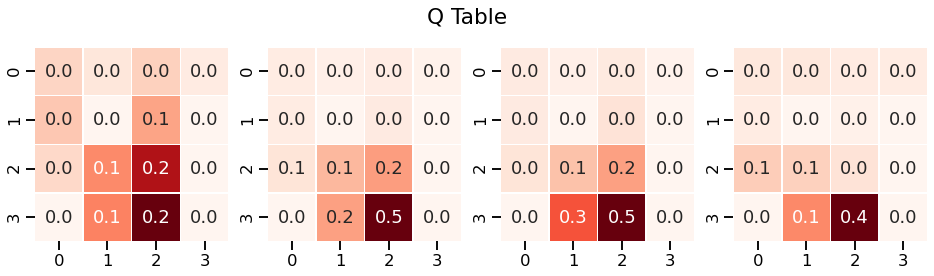

In [15]:
environment = gym.make('FrozenLake-v0')
environment._max_episode_steps = 1000

q_array = sarsa(environment, display=False)

environment.close()

qtable_display(q_array, title="Q Table", cbar=True)

### Display the evolution of the value function over iterations

In [16]:
q_array_history = np.array(q_array_history)
df_q_hist_list = []

for action_index in range(q_array_history.shape[2]):
    df_q_hist_list.append(pd.DataFrame(q_array_history[:, :, action_index]))

Evolution of `q_array` over iterations (one curve per state):

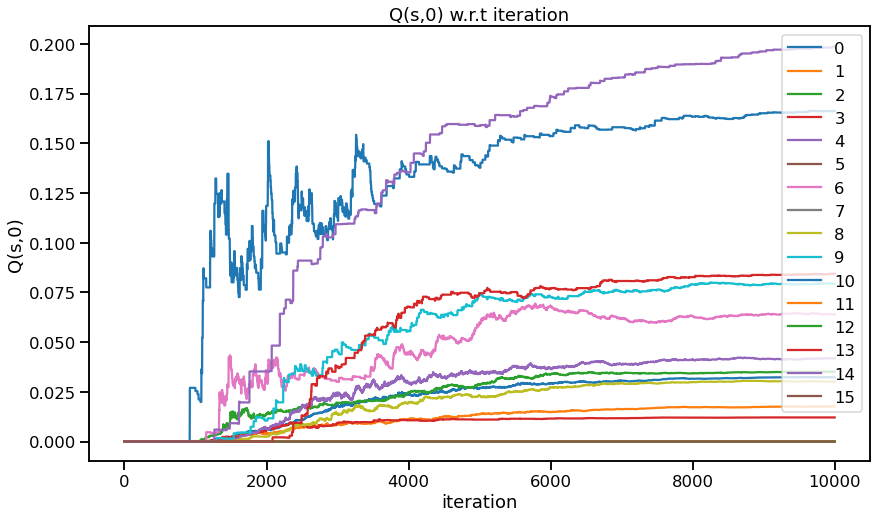

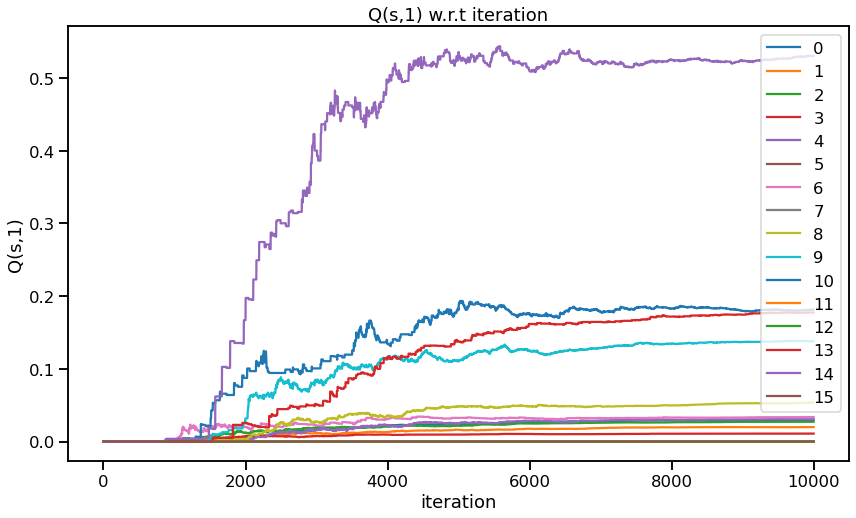

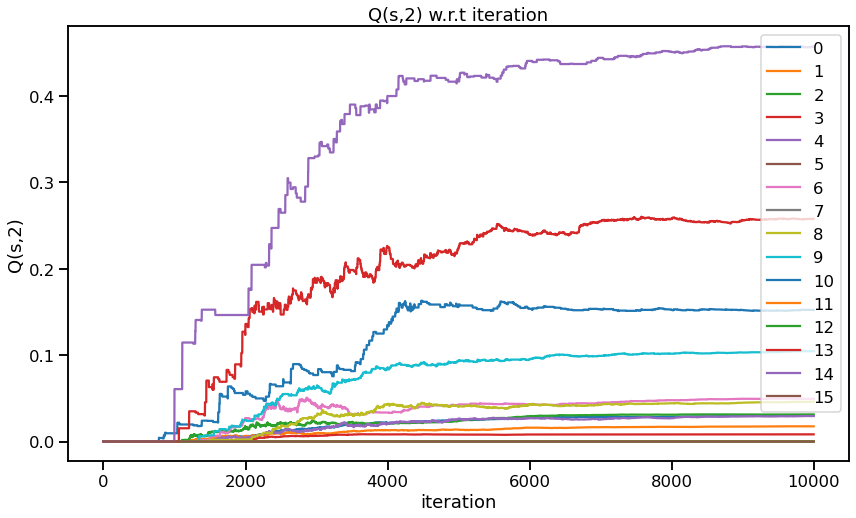

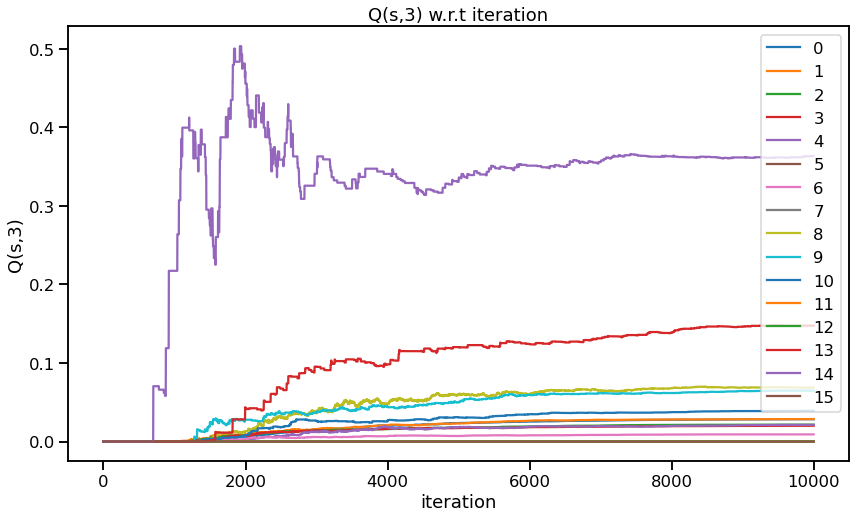

In [17]:
for action_index, df_q_hist in enumerate(df_q_hist_list):
    df_q_hist.plot(figsize=(14,8))
    plt.title("Q(s,{}) w.r.t iteration".format(action_index))
    plt.ylabel("Q(s,{})".format(action_index))
    plt.xlabel("iteration")
    plt.legend(loc='upper right');

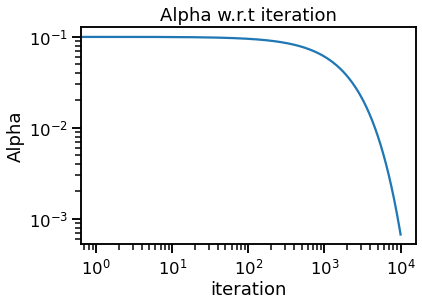

In [18]:
plt.loglog(alpha_history)
plt.title("Alpha w.r.t iteration")
plt.ylabel("Alpha")
plt.xlabel("iteration");

### Evaluate Policy Iteration with Gym

As a measure of performance, count the number of successful trials on 1000 episodes.

**Note**: OpenAI considers the task is solved if you reach 76\% of success over the episodes.

In [19]:
environment = gym.make('FrozenLake-v0')
environment._max_episode_steps = 1000

reward_list = []
NUM_EPISODES = 1000

for episode_index in range(NUM_EPISODES):
    state = environment.reset()
    done = False
    #t = 0

    while not done:
        #action = epsilon_greedy_policy(state, q_array, epsilon)
        action = greedy_policy(state, q_array)
        state, reward, done, info = environment.step(action)

    reward_list.append(reward)

reward_df = pd.DataFrame(reward_list)

print('Average reward (which is equivalent to a "success rate" in the FrozenLake environment as the total rewards in this environment are either 0 or 1):', np.average(reward_df))

environment.close()

Average reward (which is equivalent to a "success rate" in the FrozenLake environment as the total rewards in this environment are either 0 or 1): 0.612


## Exercise 5: Implement the QLearning algorithm

Another reinforcement learning algorithm is the so called Q-Learning algorithm.
The fundamental difference with SARSA is that it is an off-policy algorithm.
This means that it doesn't estimate the Q-function of its current policy but it estimates the value of another policy which is the optimal one.
To do so, it uses the following update rule:
$$
Q_{t+1}(s_t, a_t) \leftarrow Q_t(s_t, a_t) + \alpha \left( r_t + \gamma \max_b Q_t(s_{t+1}, b) - Q_t(s_t, a_t) \right) .
$$

**Task**: in this exercise, you will replace the SARSA update rule by the Q-learning one and analyze the
differences in performances.

---
QLearning
---

<b>Input</b>:<br>
	$\quad\quad$ none<br>
<b>Algorithm parameter</b>:<br>
	$\quad\quad$ discount factor $\discount$<br>
	$\quad\quad$ step size $\stepsize \in (0,1]$<br>
	$\quad\quad$ small $\epsilon > 0$<br><br>

Initialize arbitrarily $\qtable(\state, \action) ~~~ \forall \state \in \statespace, \action \in \actionspace(\state)$<br>
$\qtable(\finalstate, \cdot) = 0 ~~~ \forall \finalstate \in \statespaceterm$ (initialize finale states)<br><br>

<b>FOR EACH</b> episode<br>
	$\quad$ $\statet \leftarrow \text{env.reset}()$<br>
	$\quad$ <b>DO</b> <br>
		$\quad\quad$ $\actiont \leftarrow \epsilon\text{-greedy}(\statet, Q)$<br>
		$\quad\quad$ $\reward, \newstatet \leftarrow \text{env.step}(\actiont)$<br>
		$\quad\quad$ $Q(\statet,\actiont) \leftarrow Q(\statet,\actiont) + \stepsize \left[ \underbrace{\reward + \discount ~ \max_{\action} Q(\newstatet, \action) ~ - ~ Q(\statet,\actiont)}_{\text{TD error}} \right]$<br>
		$\quad\quad$ $\statet \leftarrow \newstatet$<br>
	$\quad$ <b>UNTIL</b> $\statet$ is final

In [20]:
q_array_history = []
alpha_history = []

DISPLAY_EVERY_N_EPISODES = 50

def q_learning(environment, alpha=0.1, alpha_factor=0.9995, gamma=0.99, epsilon=0.5, num_episodes=10000, display=False):
    num_states = environment.observation_space.n
    num_actions = environment.action_space.n
    q_array = np.zeros([num_states, num_actions])   # Initial Q table

    for episode_index in range(num_episodes):
        if display and episode_index % DISPLAY_EVERY_N_EPISODES == 0:
            qtable_display(q_array, title="Q table", cbar=True)
        else:
            print('.', end="")
        q_array_history.append(q_array.copy())
        alpha_history.append(alpha)

        ### BEGIN SOLUTION ###

        is_final_state = False
        state = environment.reset()

        # Update alpha
        if alpha_factor is not None:
            alpha = alpha * alpha_factor

        while not is_final_state:
            action = epsilon_greedy_policy(state, q_array, epsilon)
            new_state, reward, is_final_state, info = environment.step(action)
            
            #if reward > 0:
            #    print(reward)
            
            #if is_final_state:
            #    print(state)
            
            new_action = greedy_policy(new_state, q_array)
            q_array[state, action] = q_array[state, action] + alpha * (reward + gamma * q_array[new_state, new_action] - q_array[state, action])
            
            state = new_state
        
        ### END SOLUTION ###
    
    return q_array

**Note**: In the following cell, the `display` argument can be set to `True` to see the evolution of the action-value function `q_array` over iterations.

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

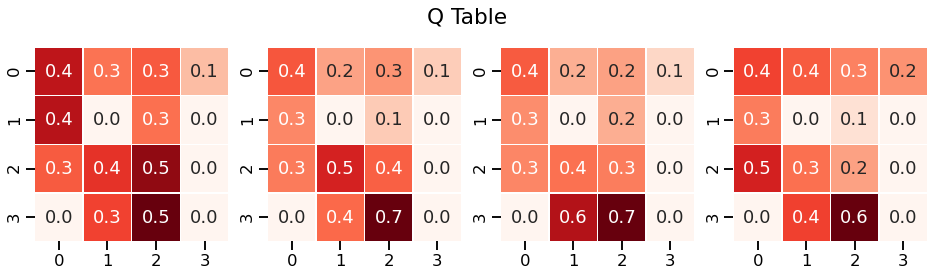

In [21]:
environment = gym.make('FrozenLake-v0')
environment._max_episode_steps = 1000

q_array = q_learning(environment, display=False)

environment.close()

qtable_display(q_array, title="Q Table", cbar=True)

### Display the evolution of the value function over iterations

In [22]:
q_array_history = np.array(q_array_history)
df_q_hist_list = []

for action_index in range(q_array_history.shape[2]):
    df_q_hist_list.append(pd.DataFrame(q_array_history[:, :, action_index]))

Evolution of `q_array` over iterations (one curve per state):

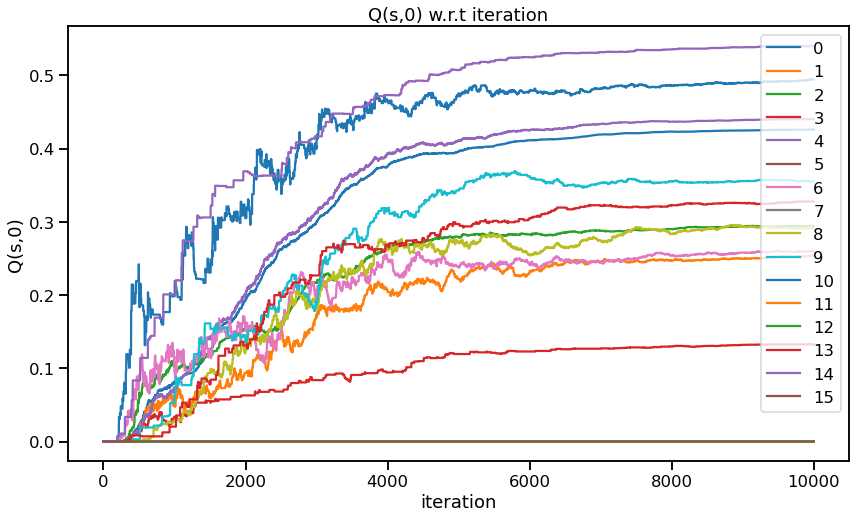

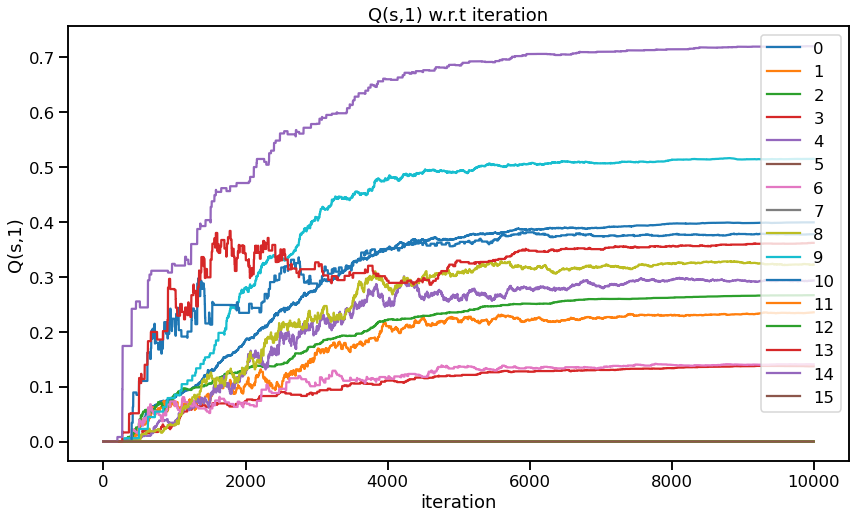

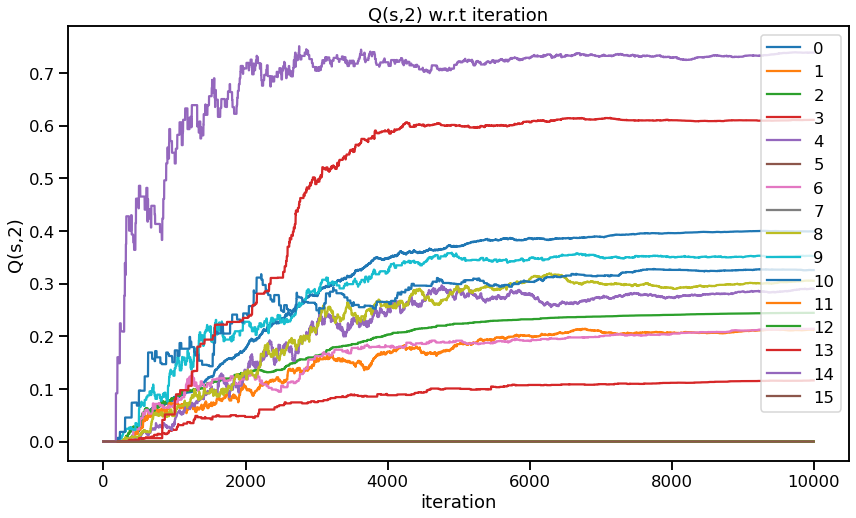

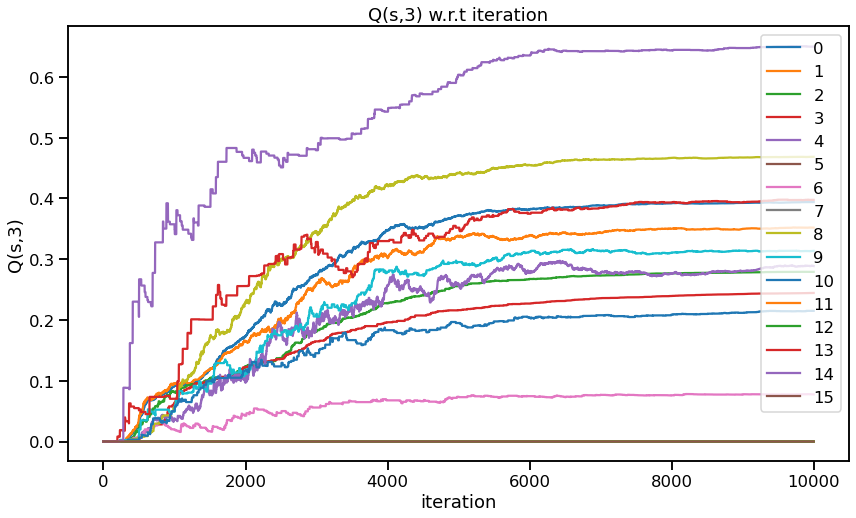

In [23]:
for action_index, df_q_hist in enumerate(df_q_hist_list):
    df_q_hist.plot(figsize=(14,8))
    plt.title("Q(s,{}) w.r.t iteration".format(action_index))
    plt.ylabel("Q(s,{})".format(action_index))
    plt.xlabel("iteration")
    plt.legend(loc='upper right');

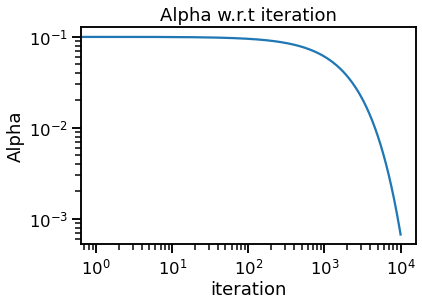

In [24]:
plt.loglog(alpha_history)
plt.title("Alpha w.r.t iteration")
plt.ylabel("Alpha")
plt.xlabel("iteration");

### Evaluate Policy Iteration with Gym

As a measure of performance, count the number of successful trials on 1000 episodes.

**Note**: OpenAI considers the task is solved if you reach 76\% of success over the episodes.

In [25]:
environment = gym.make('FrozenLake-v0')
environment._max_episode_steps = 1000

reward_list = []
NUM_EPISODES = 1000

for episode_index in range(NUM_EPISODES):
    state = environment.reset()
    done = False
    #t = 0

    while not done:
        #action = epsilon_greedy_policy(state, q_array, epsilon)
        action = greedy_policy(state, q_array)
        state, reward, done, info = environment.step(action)

    reward_list.append(reward)

reward_df = pd.DataFrame(reward_list)

print('Average reward (which is equivalent to a "success rate" in the FrozenLake environment as the total rewards in this environment are either 0 or 1):', np.average(reward_df))

environment.close()

Average reward (which is equivalent to a "success rate" in the FrozenLake environment as the total rewards in this environment are either 0 or 1): 0.671
